# 0c - Shift regional volume change timeseries to an initial starting point at year 2020

- shifts all time series to roughly the 2020 volume (by finding a simulation year near to the 2020 volume, and redefining this to be the `year_after_2020` zero state)
- creates the Hugonnet et al. 2021 / Farinotti et al. 2019 summary statistics that also includes the estimated median RGI year and the 2020 regional volume/mass:
    - saved as an intermediate step in `../data/0_rgi_vs_2020_volume_hugonnet_estimates.csv`
- creates the shifted timeseries dataset that is used later in most analysis (eight glacier models are included here, not anymore OGGM-VAS or OGGM_v153):
    - `../data/GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled_extended_repeat_last_101yrs_via_5yravg.nc`
- creates some test figures to show how much simulation years are shifted and how well the 2020 volume is matched
---

- thought process just to get the steady-state relative to 2020 approach: 
    - just to get the steady-state relative to 2020, it is relatively straight forward:
  - we scale all models first scaled to match Farinotti et al. at RGI date (in previous notebook)
  - we estimate the best estimate regional volume and divide by that instead of dividing through Farinotti (i.e., dividing through initial state of simulation year 0)
  - computationally we can just multiply by Farinotti and then divide by new 2020 volume
    - i.e., we can use the time scales relative to initial state and just multiply them with a factor that is  `new_scaling_factor =  Farinotti volume / 2020 volume`
- but as we also want to shift the timeseries, we search for the year where the volume is most similar to the 2020 volume and start the timeseries instead there... 

In [1]:
DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs'

# get weigthed median 
from statsmodels.stats.weightstats import DescrStatsW

import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from moepy import lowess, eda

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, get_glob_temp_exp

path_merged_runs_scaled_extend = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

pd_global_temp_exp = pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)

hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)
pal_models

 
ds_reg_models = ds_reg_models.sel(model_author=hue_order)
ds_reg_models_vol = ds_reg_models.volume_m3

['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [2]:
print(pd.__version__, xr.__version__, np.__version__)


2.1.3 2023.11.0 1.24.4


In [3]:
pd_global_temp_exp_m  = get_glob_temp_exp(region='global')
pd_global_temp_exp_m

temp_ch_ipcc  region
gcm         period_scenario                       
gfdl-esm4   1851-1870_hist        0.231409  global
            1901-1920_hist        0.478289  global
            1951-1970_hist        0.392281  global
            1995-2014_hist        0.901467  global
            2021-2040_ssp126      1.493792  global
...                                    ...     ...
ukesm1-0-ll 2081-2100_ssp370      5.840495  global
            2021-2040_ssp585      2.319733  global
            2041-2060_ssp585      3.646967  global
            2061-2080_ssp585      5.230543  global
            2081-2100_ssp585      6.884361  global

[80 rows x 2 columns]

In [4]:
ds_reg_models_vol_stack = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
pd_global_temp_exp_m = get_glob_temp_exp(region='global')
ds_reg_models_vol_stack = ds_reg_models_vol_stack.assign_coords(temp_ch_ipcc = ('experiments',
                                                                pd_global_temp_exp_m.loc[ds_reg_models_vol_stack.experiments, # make sure thatwe use the same experiments pd_global_temp_exp_m_glac
                                                                                   'temp_ch_ipcc']))

In [5]:
np.testing.assert_allclose(ds_reg_models_vol_stack.experiments.temp_ch_ipcc.min().values.round(2), -0.14)
np.testing.assert_allclose(ds_reg_models_vol_stack.experiments.temp_ch_ipcc.max().values.round(2), 6.88)

**get the regional volume changes according to Hugonnet et al. (2021)**

In [6]:
pd_hugonnet_ed_table_12 = pd.read_csv('../data/data_from_others/hugonnet_et_al_2021_ED_table_1_2_data.csv')
# we compute it here once for the 20-year average, but decided later that we actually use the 5-yr avg. approach
pd_hugonnet_ed_table_12_20yrs = pd_hugonnet_ed_table_12.loc[pd_hugonnet_ed_table_12.period == '2000-01-01_2020-01-01']
pd_hugonnet_ed_table_12_20yrs_glob = pd_hugonnet_ed_table_12_20yrs.loc[pd_hugonnet_ed_table_12_20yrs.reg == 21] # Globally 
pd_hugonnet_ed_table_12_20yrs
np.testing.assert_allclose(pd_hugonnet_ed_table_12_20yrs['dmdt']/pd_hugonnet_ed_table_12_20yrs['dvoldt'], 8.5e-10, rtol=1e-3)
# do we use the 900 factor to correct for it (or the 850 kg m-3that is used in Hugonnet!!!
#  or directly the vol_dt rates???
# discussed that with Fabien: we use here the vol_dt rates to be more consistent for all models,
# however, for some models, like OGGM, it would be more correct to use the Hugonnet mass changs 
# (this is what OGGM simulates internally), and then convert to volume
# changes via the 900 conversion factor (instead of 850). ...


In [7]:
import oggm
# get the RGI area / ITMIX volumes of the glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))

frgi = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf = odf.loc[(odf['Connect'] == 0) | (odf ['Connect'] ==1)]

pd_rgi_stats_w_hugonnet = pd.DataFrame(index=rgi_regs)
for rgi_reg in rgi_regs:
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    rgidf = odf.loc[odf['O1Region'] == rgi_reg]
    
    
    years_rgi = np.array([int(x[:4]) for x in rgidf.BgnDate])
    area_rgi = rgidf.Area
    wq = DescrStatsW(data=years_rgi,
                     weights=area_rgi)
    med_weighted_yr = wq.quantile(probs=np.array([0.5]), return_pandas=False).squeeze()
    pd_rgi_stats_w_hugonnet.loc[rgi_reg,'rgi_year_weighted_median'] =  med_weighted_yr
    pd_rgi_stats_w_hugonnet.loc[rgi_reg,'regional_volume_m3_itmix'] = df_itmix.loc[rgidf.index]['vol_itmix_m3'].sum()
    
    yr_diff = 2020-med_weighted_yr
    if yr_diff>20:
        yr_diff = 20 # maximum 20 years!!! , as we don't know about the changes before year 2000
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'yr_diff_rgi_vs_2020'] = yr_diff
    
    dvoldt = pd_hugonnet_ed_table_12_20yrs.loc[pd_hugonnet_ed_table_12_20yrs.reg == int(rgi_reg)]['dvoldt']
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'dvoldt_m3_hugonnet'] = dvoldt.values
    for p in ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01', '2010-01-01_2015-01-01', '2015-01-01_2020-01-01'][::-1]:
        dvoldt_p = pd_hugonnet_ed_table_12.loc[(pd_hugonnet_ed_table_12.period == p) & (pd_hugonnet_ed_table_12.reg == int(rgi_reg))]['dvoldt']
        pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] = dvoldt_p.values

    _reg = rgidf['O1Region'].unique().squeeze()
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'region'] = _reg
    
    loss_m3_p = 0
    yr_diff_reduced = yr_diff #.copy()
    for p in ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01', '2010-01-01_2015-01-01', '2015-01-01_2020-01-01'][::-1]:
        if yr_diff_reduced <=5:
            loss_m3_p += pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * yr_diff_reduced
            break
        else:
            loss_m3_p += pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * 5 
            yr_diff_reduced -= 5 # reduce it by 5 years
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'loss_m3_via_5yravg'] = loss_m3_p
    
    ### same for the "gain" until 2000
    gain_m3_p = 0
    yr_diff_reduced_gain = 20-yr_diff #.copy()
    for p in ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01', '2010-01-01_2015-01-01', '2015-01-01_2020-01-01']:
        if yr_diff_reduced_gain <=5:
            gain_m3_p -= pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * yr_diff_reduced_gain
            break
        else:
            gain_m3_p -= pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * 5 
            yr_diff_reduced_gain -= 5 # reduce it by 5 years
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'gain_m3_via_5yravg'] = gain_m3_p


loss_m3 = pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet'] * pd_rgi_stats_w_hugonnet['yr_diff_rgi_vs_2020']
gain_m3 = -pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet'] * (20-pd_rgi_stats_w_hugonnet['yr_diff_rgi_vs_2020']) 

approach = '_via_5yravg'
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + pd_rgi_stats_w_hugonnet['loss_m3_via_5yravg']
# negative because it is a gain as the inventory date is defined to be at yr 2000 or afterwards
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + pd_rgi_stats_w_hugonnet['gain_m3_via_5yravg']

approach = '_via_20yravg' #'_avg_20yr'
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + loss_m3
# negative because it is a gain as the inventory date is defined to be at yr 2000 or afterwards
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + gain_m3

# estimate it globally by summing over the regional 2020 estimates to first get a global estimate for 2020
pd_rgi_stats_w_hugonnet.loc['Globally', 'region'] = 'Globally'
for approach in ['_via_5yravg', '_via_20yravg']:
    pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'] = pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}'].sum()
    pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2000{approach}'] = pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}'].sum()
pd_rgi_stats_w_hugonnet.loc['Globally', 'regional_volume_m3_itmix'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'].sum()
pd_rgi_stats_w_hugonnet.loc['Globally', 'dvoldt_m3_hugonnet'] = pd_hugonnet_ed_table_12_20yrs_glob['dvoldt'].values
# also compute median weigted global RGI year
years_rgi = np.array([int(x[:4]) for x in odf.BgnDate])
area_rgi = odf.Area
wq = DescrStatsW(data=years_rgi,
                 weights=area_rgi)
med_weighted_yr = wq.quantile(probs=np.array([0.5]), return_pandas=False).squeeze()
pd_rgi_stats_w_hugonnet.loc['Globally','rgi_year_weighted_median'] =  med_weighted_yr
yr_diff = 2020-med_weighted_yr
if yr_diff>20:
    yr_diff = 20 # maximum 20 years!!! , as we don't know about the changes before year 2000
pd_rgi_stats_w_hugonnet.loc['Globally', 'yr_diff_rgi_vs_2020'] = yr_diff
for approach in ['_via_5yravg', '_via_20yravg']:
    pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix_vs_2020'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}']
    pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix_vs_2000'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}']

    pd_rgi_stats_w_hugonnet[f'regional_dvol_dt_2000_2019_vs_2020_vol{approach}'] = pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}']
    pd_rgi_stats_w_hugonnet[f'regional_dvol_dt_2000_2019_vs_2000_vol{approach}'] = pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}']

In [8]:
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_20yravg'],
                           pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg'], rtol = 0.025)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_20yravg'],
                           pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_5yravg'], rtol = 0.02)


In [9]:
pd_rgi_stats_w_hugonnet

,rgi_year_weighted_median,regional_volume_m3_itmix,yr_diff_rgi_vs_2020,dvoldt_m3_hugonnet,dvoldt_m3_hugonnet_2015-01-01_2020-01-01,dvoldt_m3_hugonnet_2010-01-01_2015-01-01,dvoldt_m3_hugonnet_2005-01-01_2010-01-01,dvoldt_m3_hugonnet_2000-01-01_2005-01-01,region,loss_m3_via_5yravg,gain_m3_via_5yravg,regional_volume_m3_2020_via_5yravg,regional_volume_m3_2000_via_5yravg,regional_volume_m3_2020_via_20yravg,regional_volume_m3_2000_via_20yravg,regional_volume_m3_itmix_vs_2020,regional_volume_m3_itmix_vs_2000,regional_dvol_dt_2000_2019_vs_2020_vol_via_5yravg,regional_dvol_dt_2000_2019_vs_2000_vol_via_5yravg,regional_dvol_dt_2000_2019_vs_2020_vol_via_20yravg,regional_dvol_dt_2000_2019_vs_2000_vol_via_20yravg
01,2010.0,1.897846e+13,10.0,-7.841362e+10,-1.026278e+11,-8.294236e+10,-6.987370e+10,-5.821064e+10,01,-9.278508e+11,6.404217e+11,1.805061e+13,1.961888e+13,1.819432e+13,1.976259e+13,1.043098,0.960322,-0.004344,-0.003997,-0.004310,-0.003968
02,2004.0,1.046788e+12,16.0,-8.894468e+09,-1.444629e+10,-1.071820e+10,-6.765078e+09,-3.648306e+09,02,-1.632961e+11,1.459322e+10,8.834921e+11,1.061381e+12,9.044768e+11,1.082366e+12,1.157341,0.967130,-0.010067,-0.008380,-0.009834,-0.008218
03,1999.0,2.833124e+13,20.0,-3.595335e+10,-3.397691e+10,-4.138025e+10,-4.017828e+10,-2.827794e+10,03,-7.190670e+11,0.000000e+00,2.761218e+13,2.833124e+13,2.761218e+13,2.833124e+13,1.026042,1.000000,-0.001302,-0.001269,-0.001302,-0.001269
04,2001.0,8.611335e+12,19.0,-3.117858e+10,-3.513663e+10,-3.412745e+10,-2.957945e+10,-2.587080e+10,04,-5.977009e+11,2.587080e+10,8.013634e+12,8.637206e+12,8.018942e+12,8.642513e+12,1.073874,0.996392,-0.003891,-0.003610,-0.003888,-0.003608
05,2001.0,1.569203e+13,19.0,-4.178265e+10,-3.649135e+10,-4.607979e+10,-4.144563e+10,-4.311382e+10,05,-7.925391e+11,4.311382e+10,1.489949e+13,1.573515e+13,1.489816e+13,1.573382e+13,1.053286,0.997344,-0.002804,-0.002655,-0.002805,-0.002656
06,2000.0,3.769574e+12,20.0,-1.101284e+10,-7.935130e+09,-1.022784e+10,-1.261888e+10,-1.326952e+10,06,-2.202568e+11,0.000000e+00,3.549317e+12,3.769574e+12,3.549317e+12,3.769574e+12,1.062056,1.000000,-0.003103,-0.002922,-0.003103,-0.002922
07,2008.0,7.470376e+12,12.0,-1.239900e+10,-1.857601e+10,-1.266039e+10,-9.532151e+09,-8.827463e+09,07,-1.752463e+11,7.273377e+10,7.295130e+12,7.543110e+12,7.321588e+12,7.569568e+12,1.020322,0.986896,-0.001700,-0.001644,-0.001693,-0.001638
08,2002.0,2.985090e+11,18.0,-1.961838e+09,-1.584180e+09,-2.056187e+09,-1.951492e+09,-2.255492e+09,08,-3.472577e+10,4.510983e+09,2.637832e+11,3.030200e+11,2.631959e+11,3.024327e+11,1.134170,0.987026,-0.007437,-0.006474,-0.007454,-0.006487
09,2001.0,1.464022e+13,19.0,-1.224699e+10,-1.537172e+10,-1.247618e+10,-1.128182e+10,-9.858226e+09,09,-2.350815e+11,9.858226e+09,1.440514e+13,1.465008e+13,1.440753e+13,1.465247e+13,1.016151,0.999164,-0.000850,-0.000836,-0.000850,-0.000836
10,2011.0,1.357811e+11,9.0,-1.479667e+09,-1.637005e+09,-1.560954e+09,-1.445651e+09,-1.275057e+09,10,-1.442884e+10,1.516450e+10,1.213523e+11,1.509456e+11,1.224641e+11,1.520575e+11,1.108742,0.892959,-0.012193,-0.009803,-0.012082,-0.009731


In [10]:
# test for RGI11
rgi_reg = '11'
pd_rgi_stats_w_hugonnet_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg]
rgi_yr = pd_rgi_stats_w_hugonnet_reg['rgi_year_weighted_median']
yr_diff = 2020 - rgi_yr
print(yr_diff, rgi_reg)
assert np.all(yr_diff == pd_rgi_stats_w_hugonnet_reg['yr_diff_rgi_vs_2020'])
sum_20yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*5 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*5)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*20 , sum_20yr_from5yr)

sum_17yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*5 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*2)
# this should be exactly the same as the approach applied above 
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['loss_m3_via_5yravg'], sum_17yr_from5yr)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*17 , sum_17yr_from5yr, rtol = 0.01) # 0.025)
# for the gain, we just need in this test case 3 years 
np.testing.assert_allclose(-pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*3, pd_rgi_stats_w_hugonnet_reg['gain_m3_via_5yravg'])

# test for RGI10
rgi_reg = '10'
pd_rgi_stats_w_hugonnet_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg]
rgi_yr = pd_rgi_stats_w_hugonnet_reg['rgi_year_weighted_median']
yr_diff = 2020 - rgi_yr
print(yr_diff, rgi_reg)
assert np.all(yr_diff == pd_rgi_stats_w_hugonnet_reg['yr_diff_rgi_vs_2020'])
sum_20yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*5 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*5)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*20 , sum_20yr_from5yr)

sum_9yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*4 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*0 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*0)
# this should be exactly the same as the approach applied above 
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['loss_m3_via_5yravg'], sum_9yr_from5yr)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*9 , sum_9yr_from5yr, rtol = 0.08)  # this is higher 
# for the gain, we just need in this test case 3 years 
np.testing.assert_allclose(-pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*5 -pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 - pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*1,
                           pd_rgi_stats_w_hugonnet_reg['gain_m3_via_5yravg'])

17.0 11
9.0 10


Text(0.5, 1.0, 'regional volume approach comparisons')

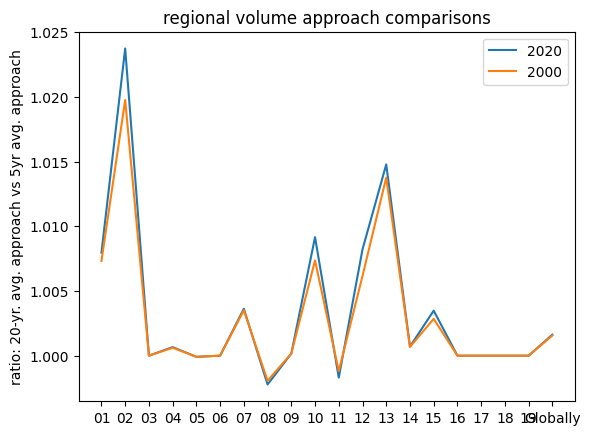

In [11]:
plt.plot(pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_20yravg']/pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg'], label='2020')
plt.ylabel('ratio: 20-yr. avg. approach vs 5yr avg. approach')
plt.plot(pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_20yravg']/pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_5yravg'], label = '2000')
plt.ylabel('ratio: 20-yr. avg. approach vs 5yr avg. approach')

plt.legend()

plt.title('regional volume approach comparisons')

In [12]:
# we will collect some other data and store that then in 3_shift_summary ... 
pd_rgi_stats_w_hugonnet.to_csv(f'../0_pre_post_processing/_intermediate_data/rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv') 

In [13]:
pd_rgi_stats_w_hugonnet.columns

Index(['rgi_year_weighted_median', 'regional_volume_m3_itmix',
       'yr_diff_rgi_vs_2020', 'dvoldt_m3_hugonnet',
       'dvoldt_m3_hugonnet_2015-01-01_2020-01-01',
       'dvoldt_m3_hugonnet_2010-01-01_2015-01-01',
       'dvoldt_m3_hugonnet_2005-01-01_2010-01-01',
       'dvoldt_m3_hugonnet_2000-01-01_2005-01-01', 'region',
       'loss_m3_via_5yravg', 'gain_m3_via_5yravg',
       'regional_volume_m3_2020_via_5yravg',
       'regional_volume_m3_2000_via_5yravg',
       'regional_volume_m3_2020_via_20yravg',
       'regional_volume_m3_2000_via_20yravg',
       'regional_volume_m3_itmix_vs_2020', 'regional_volume_m3_itmix_vs_2000',
       'regional_dvol_dt_2000_2019_vs_2020_vol_via_5yravg',
       'regional_dvol_dt_2000_2019_vs_2000_vol_via_5yravg',
       'regional_dvol_dt_2000_2019_vs_2020_vol_via_20yravg',
       'regional_dvol_dt_2000_2019_vs_2000_vol_via_20yravg'],
      dtype='object')

- according to Hugonnet et al. estimates 3% compared to Farinotti got removed until 2020 globally. In RGI11 it is 36% (also a lot in RGI12, RGI16 and RGI18), in RGI09, RGI03 and RGI19, it is only 1 %
    - when accounting for the RGI year differences, we can instead look at the regional volume differences relative to the 2020 volume, and there we see e.g. 2% relative to 2020 volume lost in RGI11
    - Luckily, globally the RGI median area-weigted is year 2000 ...

## Create shifted timeseries netcdf 

In [15]:
approach = '_via_5yravg'

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
# allow a maximum shift of 50 years
max_year_shift = 50
# volume relative to 2020 (this is the important conversion for the steady-state analysis)
ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol_stack/pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1)
#  find the year where the volume is nearest to the 2020 volume (i.e., nearest to the perc_ideal of 100)
perc_ideal = 100
yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020.sel(simulation_year=slice(0,max_year_shift))-perc_ideal).idxmin(dim='simulation_year')
#starting_vol_most_similar_state = np.abs(ds_reg_models_vol_rel_2020_above_08.sel(simulation_year=slice(0,100))-100).idxmin(dim='simulation_year')
ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(yrs_w_most_similar_state_to_2020 = (['model_author','rgi_reg','experiments'],
                                              yrs_w_most_similar_state.data))
# make sure that the array has the right format -> then reshape to include again the "simulation year" dimension
assert np.shape(ds_reg_models_vol_rel_2020['yrs_w_most_similar_state_to_2020'].values) == (8,19,80)
new_start_yr = ds_reg_models_vol_rel_2020.simulation_year.data.reshape(1,1,5001,1) - ds_reg_models_vol_rel_2020['yrs_w_most_similar_state_to_2020'].data.reshape(8,19,1,80) # 8 glacier models
ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(year_after_2020 = (['model_author','rgi_reg',
                                                                                                            'simulation_year','experiments'],
                                              new_start_yr))

_ds_t_l = []
for rgi_reg in ds_reg_models_vol_rel_2020.rgi_reg:
    ### it is too slow if we don't do it for every region separately ... 
    _p_test = ds_reg_models_vol_rel_2020.sel(rgi_reg=rgi_reg).to_dataframe().drop(columns=['period_scenario','gcm']).reset_index()
    #_p_test = _p_test.loc[_p_test.new_start_yr>=0]
    _ds_t = _p_test.drop(columns=['extend_option']).groupby(['model_author','rgi_reg','year_after_2020','period_scenario','gcm']).mean().to_xarray()
    _ds_t = _ds_t.rename_vars({'volume_m3':'volume_rel_2020_%'})
    _ds_t_l.append(_ds_t)
    #print(rgi_reg.values)
    #_ds_t = _ds_t.sel(year_after_2020=slice(0,4900))
ds_reg_yr_shift = xr.concat(_ds_t_l, dim='rgi_reg')


In [16]:
_convert = pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1,1)
ds_reg_yr_shift['volume_m3'] = ds_reg_yr_shift['volume_rel_2020_%'] * _convert/100
_glob_vol_test = ds_reg_yr_shift['volume_m3'].sel(year_after_2020=0).median(dim='model_author').sum(dim='rgi_reg')
# above 08 should match better t
_glob_vol_test_ab_08 = _glob_vol_test.sel(period_scenario=pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=0.8].period_scenario.unique())
np.testing.assert_allclose(_glob_vol_test_ab_08, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=4e-3)
np.testing.assert_allclose(_glob_vol_test, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=3e-2)

above 0.8°C, the volume is globally matched well (within 0.5%):

In [17]:
((np.abs(_glob_vol_test_ab_08-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

<xarray.DataArray 'volume_m3' ()>
array(0.0033168)
Coordinates:
    year_after_2020  float32 0.0

below 0.8°C: maximum ~2.5% globally off 

In [18]:
((np.abs(_glob_vol_test-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

<xarray.DataArray 'volume_m3' ()>
array(0.02501124)
Coordinates:
    year_after_2020  float32 0.0

**ok, after the tests, we are ready to save the netcdf files**:

In [ ]:
# there are some variables with too many dimensions, let's remove them to reduce the size of the dataset
# check if it is really the same
assert np.all(ds_reg_yr_shift['temp_ch_ipcc'].std(dim=['model_author', 'rgi_reg', 'year_after_2020']).squeeze()< 1e-5)
# now, overwrite
ds_reg_yr_shift['temp_ch_ipcc'] = ds_reg_yr_shift['temp_ch_ipcc'].mean(dim=['model_author', 'rgi_reg', 'year_after_2020'])

# yrs_w_most_similar_state_to_2020 this is different between model_author, period_scenario, gcm and the rgi_reg, but not between year_after_2020
assert np.all(ds_reg_yr_shift['yrs_w_most_similar_state_to_2020'].std(dim=['year_after_2020']).to_dataframe().dropna().values< 1e-5)
ds_reg_yr_shift['yrs_w_most_similar_state_to_2020'] = ds_reg_yr_shift['yrs_w_most_similar_state_to_2020'].std(dim=['year_after_2020'])
# eventually also remove ds_reg_yr_shift.drop_vars(['simulation_year') --> but let's keep it inside for now...

In [19]:
ds_reg_yr_shift.to_netcdf(f'../data/GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')
ds_reg_yr_shift.to_netcdf(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

In [13]:
ds_reg_yr_shift

<xarray.Dataset>
Dimensions:                           (model_author: 8, year_after_2020: 5051,
                                       period_scenario: 16, gcm: 5, rgi_reg: 19)
Coordinates:
  * model_author                      (model_author) <U14 'CISM2' ... 'PyGEM-...
  * year_after_2020                   (year_after_2020) float32 -50.0 ... 5e+03
  * period_scenario                   (period_scenario) <U16 '1851-1870_hist'...
  * gcm                               (gcm) <U13 'gfdl-esm4' ... 'ukesm1-0-ll'
  * rgi_reg                           (rgi_reg) <U2 '01' '02' '03' ... '18' '19'
Data variables:
    simulation_year                   (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    temp_ch_ipcc                      (period_scenario, gcm) float64 0.2314 ....
    yrs_w_most_similar_state_to_2020  (model_author, rgi_reg, period_scenario, gcm) float32 ...
    volume_rel_2020_%                 (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    volume_m3                         (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...

In [8]:
ds_reg_yr_shift = xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

## Some more undocumented analysis of the shifting:

In [22]:
ds_reg_yr_shift = ds_reg_yr_shift.stack(experiments=['gcm','period_scenario'])


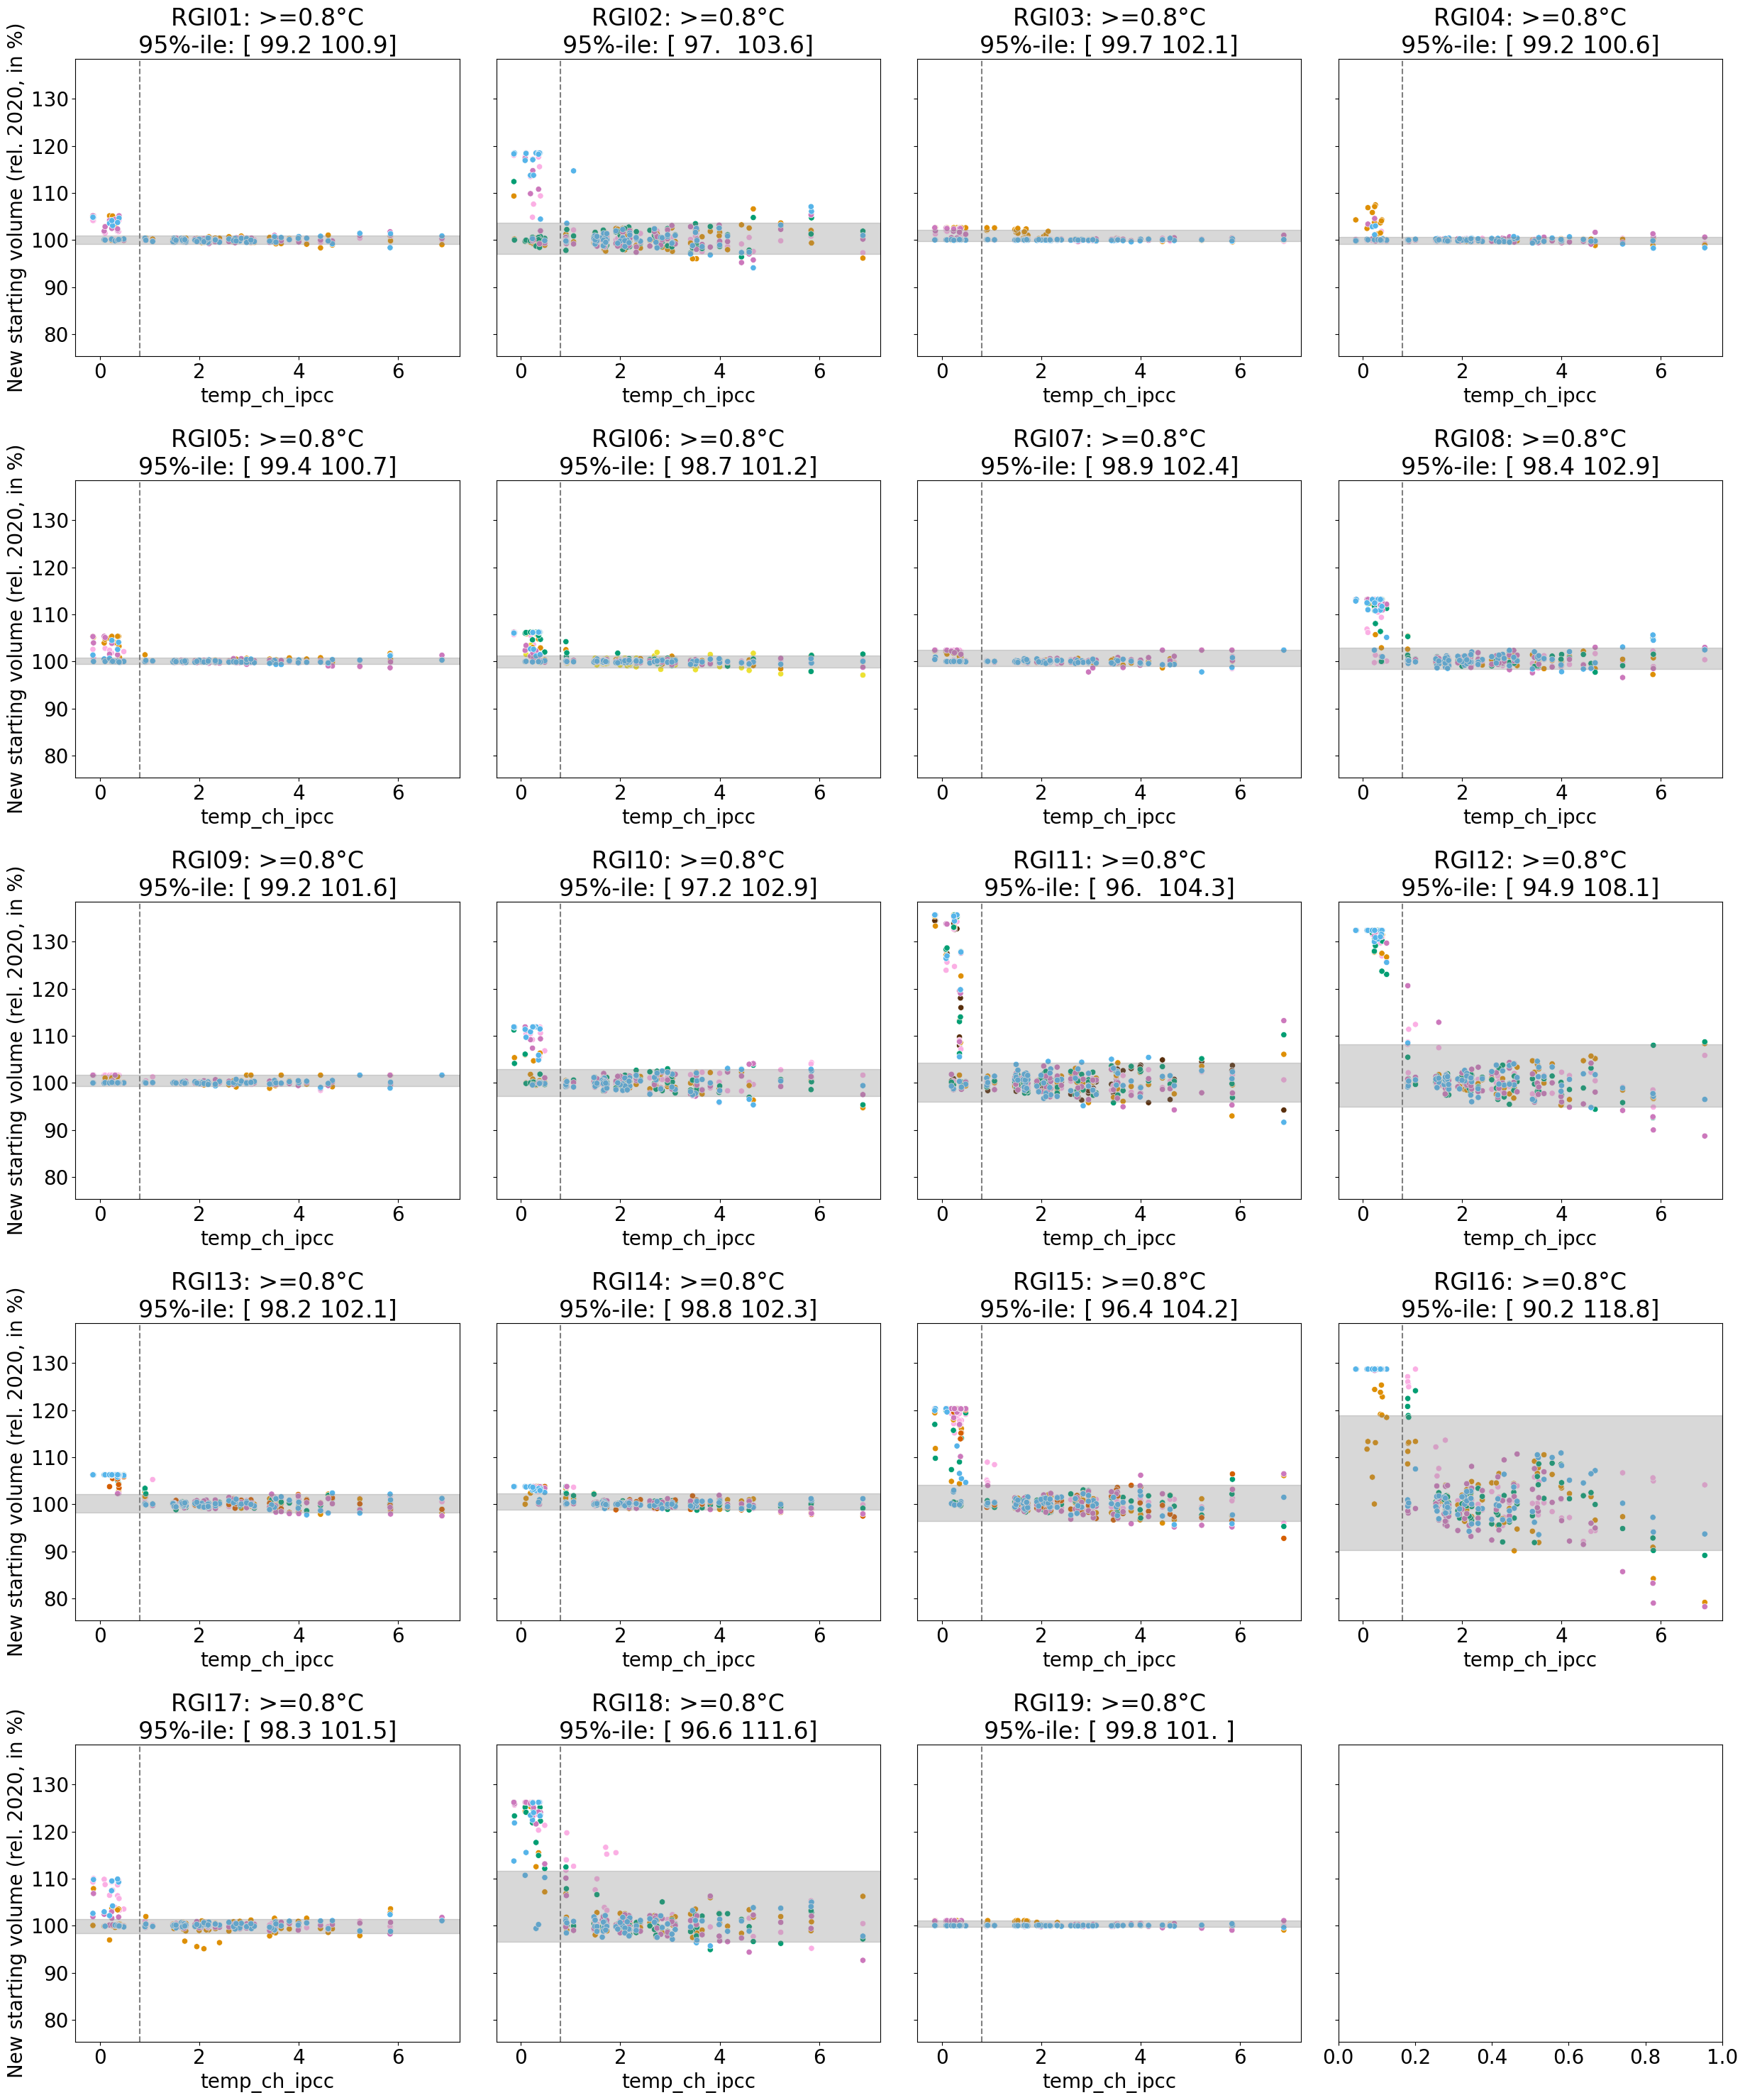

In [23]:
plt.rc('font', size=20)  

fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()

for j,rgi_reg in enumerate(ds_reg_yr_shift.rgi_reg.values):
    _t = ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg)['volume_rel_2020_%']
    #print(rgi_reg, _t.quantile([0,0.01,0.02,0.98,0.99,1]).values)
    ax = axs[j]
    sns.scatterplot(data=ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).to_dataframe().drop(columns=['gcm','period_scenario']).reset_index().dropna(),
                x='temp_ch_ipcc',
                y='volume_rel_2020_%',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    ax.axvline(0.8, color='grey',ls='--')
    #_tt = _t.where(_t.temp_ch_ipcc>=0.8)
    _tt = _t.where(ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C\n95%-ile: {_tt.quantile([0.025, 0.975]).values.round(1)}')
    ax.set_ylabel('New starting volume (rel. 2020, in %)')
plt.tight_layout()
plt.savefig(f'figures/plots_shift_timeseries/0c_shift_new_starting_volume_{DATE}.png')

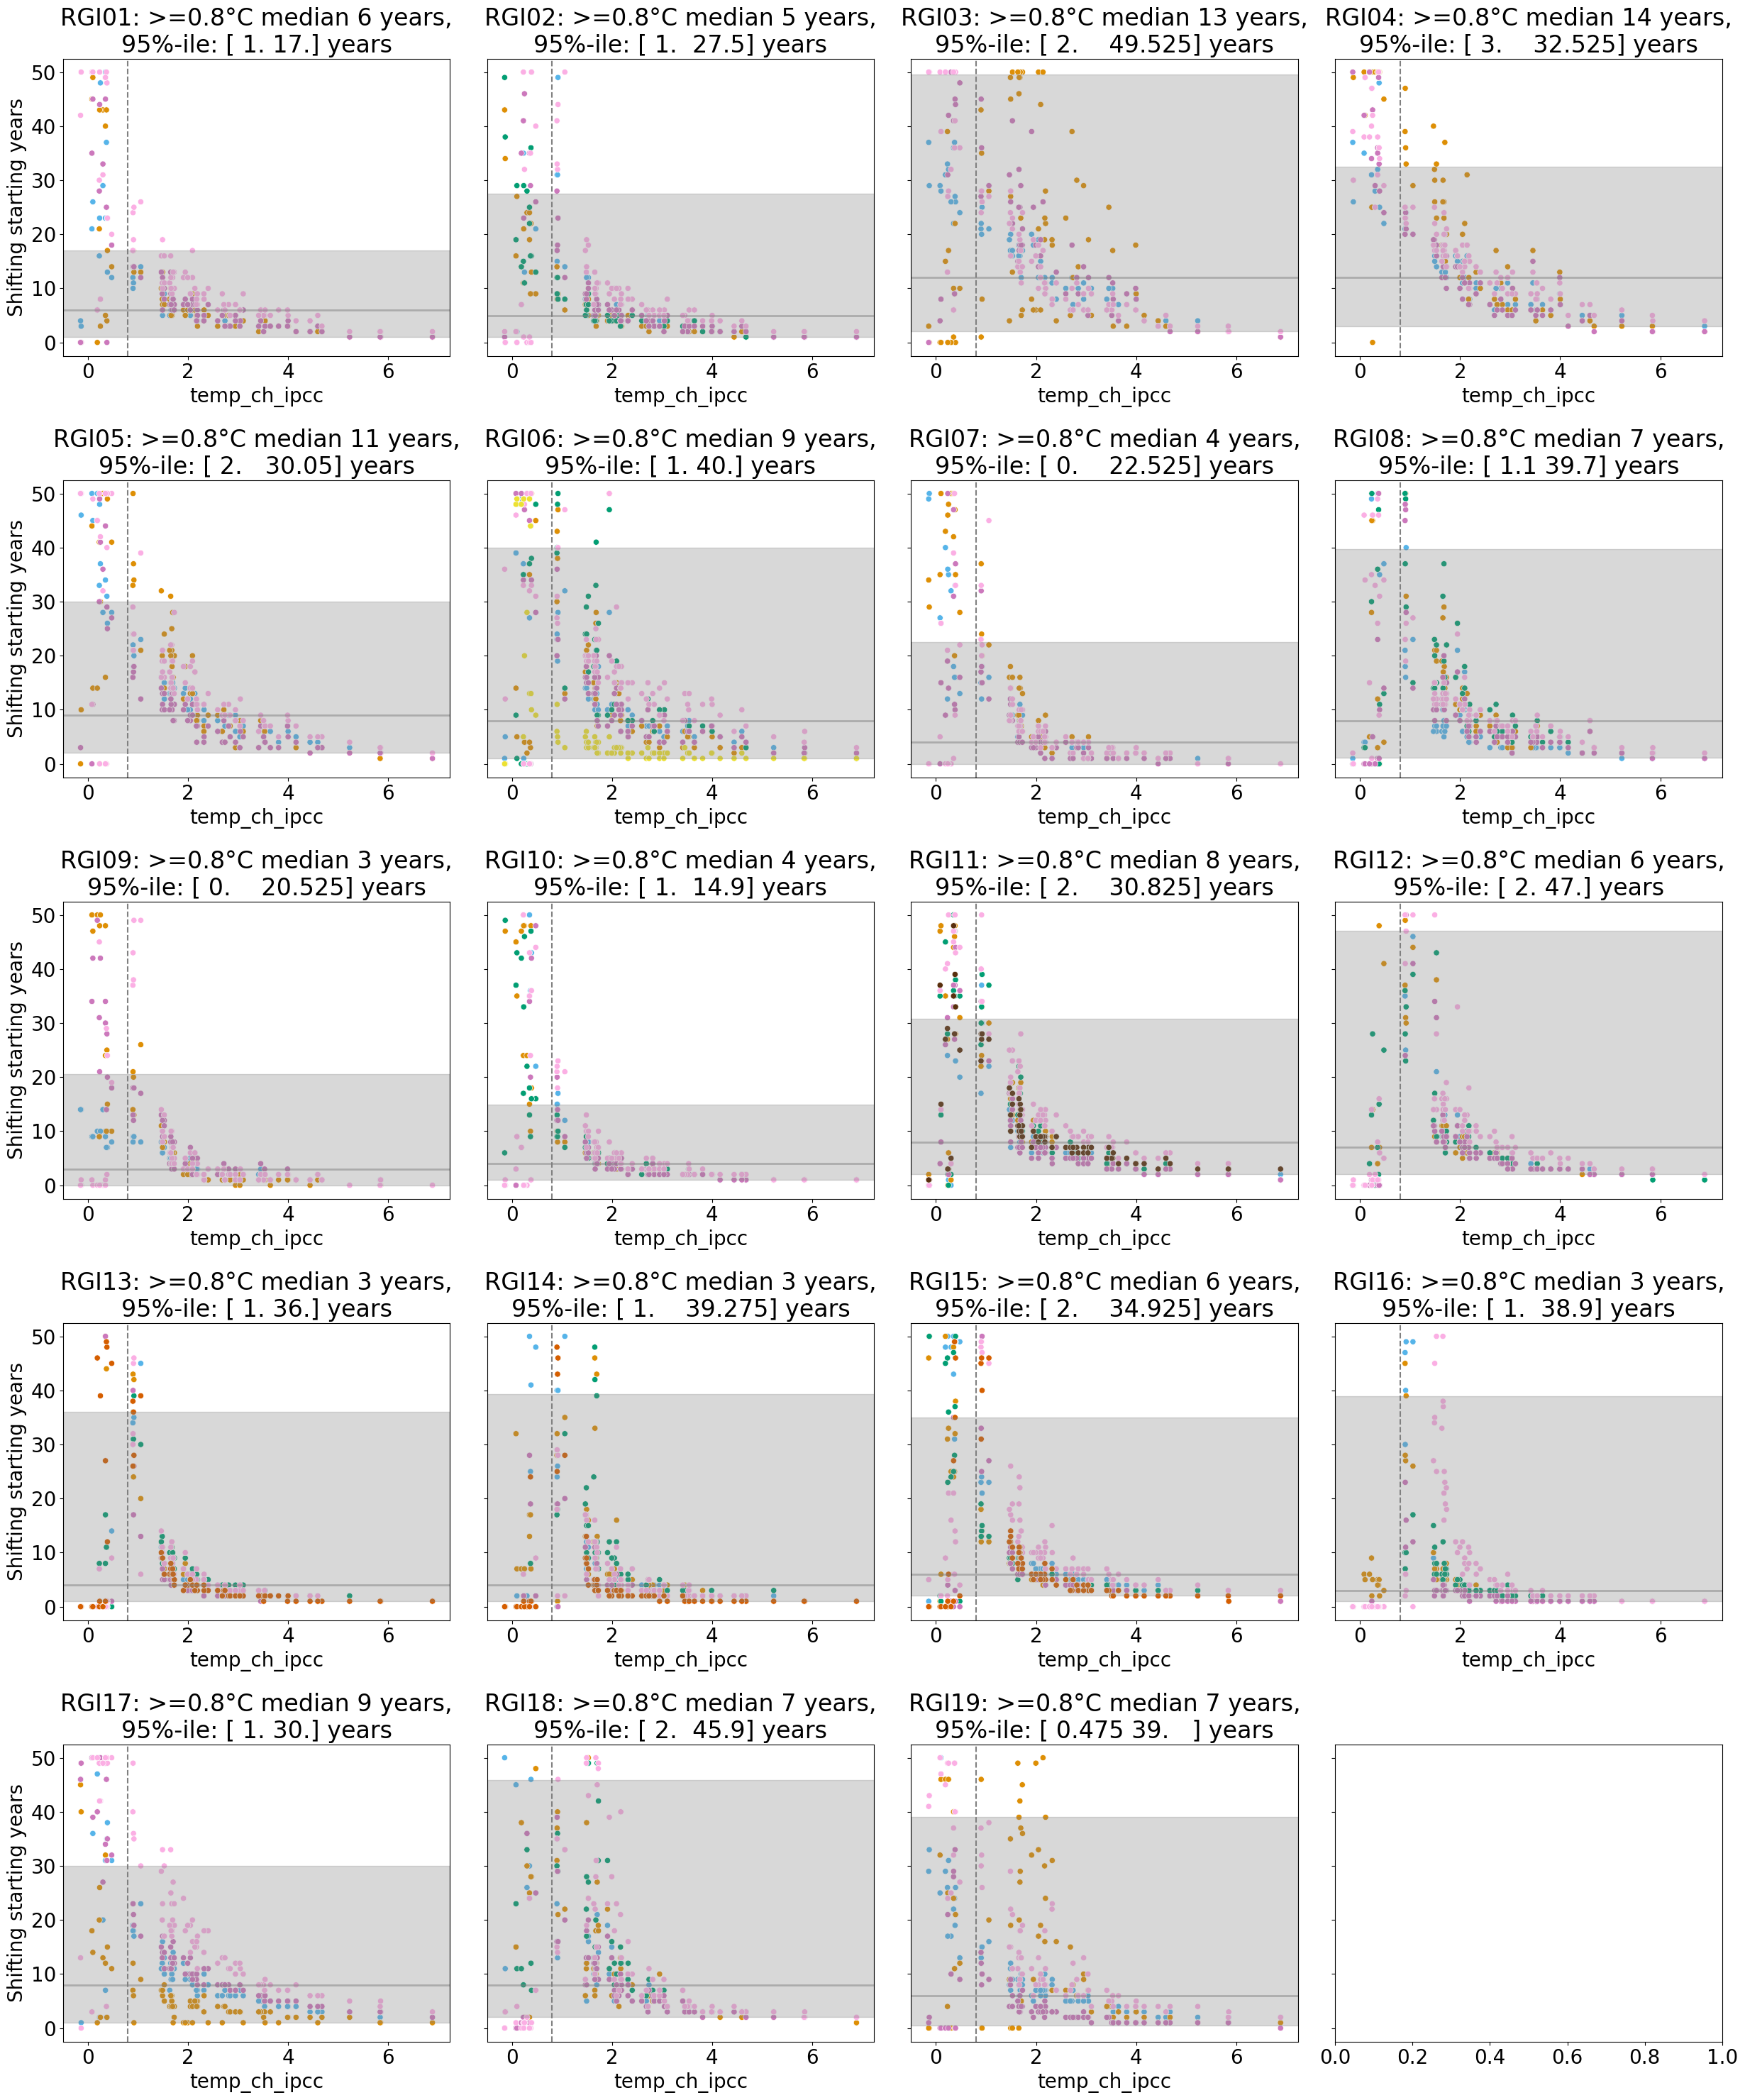

In [24]:
fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(ds_reg_yr_shift.rgi_reg.values):
    _t = yrs_w_most_similar_state.sel(rgi_reg=rgi_reg)
    ax = axs[j]
    sns.scatterplot(data=yrs_w_most_similar_state.sel(rgi_reg=rgi_reg).to_dataframe().drop(columns=['gcm', 'period_scenario']).reset_index().dropna(),
                x='temp_ch_ipcc',
                y='simulation_year',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    _tt = _t.where(ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axvline(0.8, color='grey',ls='--')

    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.axhline(_tt.quantile(0.5), color='grey',alpha = 0.5, lw=2)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C median {int(_t.quantile(0.5).values)} years,\n95%-ile: {_tt.quantile([0.025, 0.975]).values} years')
    ax.set_ylabel('Shifting starting years')
plt.tight_layout()
plt.savefig(f'figures/plots_shift_timeseries/0c_shift_new_starting_years_{DATE}.png')

## Create some regional timeseries plots 

In [ ]:
dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
#pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

ls = 'solid'
#just those roughly above 0.8
sel_periods = _glob_vol_test.sel(period_scenario=pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=0.8].period_scenario.unique())
#ds_reg_yr_shift.period_scenario.values #['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
#for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):
plt.rc('font', size=20)  
j == 0
for anonym in ['_anonym']: #'', 
    for gcm in ds_reg_yr_shift.gcm.values:
        #for rgi_reg in ['11']:
        for rgi_reg in ds_reg_yr_shift.rgi_reg.values:
            vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
            def vol_rel_2020_to_vol_km3(x, _vol_2020_reg = vol_2020_reg):
                return x*_vol_2020_reg/1e9/100
            def vol_km3_to_vol_rel_2020(x, _vol_2020_reg = vol_2020_reg):
                return x*1e9*100/_vol_2020_reg
            np.testing.assert_allclose(vol_km3_to_vol_rel_2020(vol_rel_2020_to_vol_km3(100)), 100, rtol=1e-4)
            plt.figure(figsize=(32,30))
            axs = []
            #for j,period_scenario in enumerate(sel_periods):
            for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):
            
                condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()

                if j==0 or j==2:
                    ax0=plt.subplot(5,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(5,4,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_yr_shift.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg)['volume_rel_2020_%'].to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_rel_2020_%']*vol_2020_reg/1e9/100
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==0:
                    sns.lineplot(x='year_after_2020', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls,
                                 legend='brief', lw=3, ax=ax)
                else:
                    sns.lineplot(x='year_after_2020', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls,
                                 legend=False, lw=3, ax=ax)
                ax.axvline(0,color='grey', ls='--',lw=2)
                ax2 = ax.secondary_yaxis(1., functions=(vol_km3_to_vol_rel_2020, 
                                                        vol_rel_2020_to_vol_km3)) #perc_to_slr_lin))
                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,4,8,12,16]:
                    plt.ylabel('Volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('Year after 2020', fontsize=22)

                #for m in dict_model_col.keys():
                #    yr = yrs_w_most_similar_state.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(model_author=m)
                #    print(rgi_reg, period_scenario, m, yr.values)
                #    plt.axvline(yr, ls='--', color=dict_model_col[m])
                #ax.axhline(vol_2020_reg/1e9, color='black', ls=':')

                if j==0: 
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax.text(0.02,0.94, str(period_scenario) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                        fontsize=22, transform=ax.transAxes, zorder=6)

                if j in [3,7,11,15]:
                    ax2.set_ylabel('Volume (rel. to 2020, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')
                ax.set_xlim([-50,500])
                ax2.set_xlim([-50,500])
            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
            plt.tight_layout()
            
            plt.savefig(f'figures/plots_shift_timeseries/shifted_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_{DATE}.png')
            plt.close()

**Plots to explain the selection procedure**

In [ ]:
dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
#pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

ls = 'solid'
sel_periods = ['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
#for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):

for anonym in ['_anonym']: #'', 
    for gcm in ['mri-esm2-0']:
        #for rgi_reg in ['11']:
        for rgi_reg in ['11','13','19']:
            vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
            ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol.sel(simulation_year=slice(0,50)).sel(rgi_reg=rgi_reg)/vol_2020_reg
            yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020-100).idxmin(dim='simulation_year')
            
            plt.figure(figsize=(16,14))
            axs = []
            for j,period_scenario in enumerate(sel_periods):
                condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()

                if j==0 or j==2:
                    ax0=plt.subplot(2,2,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(2,2,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(simulation_year=slice(0,50)).sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,2]:
                    plt.ylabel('Volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('Simulation year', fontsize=22)

                ax.set_xlim([-1,100])
                if j==1:
                    minip, maxip = ax.get_ylim()
                elif j==3:
                    minif, maxif = ax.get_ylim()

                for m in dict_model_col.keys():
                    yr = yrs_w_most_similar_state.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(model_author=m)
                    print(rgi_reg, period_scenario, m, yr.values)
                    plt.axvline(yr, ls='--', color=dict_model_col[m])
                ax.axhline(vol_2020_reg/1e9, color='black', ls=':')


            for j,period_scenario in enumerate(sel_periods):
                condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()
                
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(simulation_year=slice(0,100)).sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [1,3]:
                    ax2.set_ylabel('Volume (relative to initial state, in %)', fontsize=22)
                    #ax.set_yticklabels([])
                else:
                    ax2.set_ylabel('')
                    #ax2.set_yticklabels([])

                if j==1: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.94, str(period_scenario) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                        fontsize=22, transform=ax2.transAxes, zorder=6)
                    

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<2:
                    ax2.set_ylim([minip*rel,maxip*rel])
                    ax.set_xlabel('')
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])
                    


            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/plots_shift_timeseries/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_{DATE}.png')
            plt.close()

**Tests to check maximum simulation year sensitivity**

In [ ]:
max_year_shift = 200
ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol_stack/pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1)
# allow a maximum shift of 200 years
yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020.sel(simulation_year=slice(0,max_year_shift))-100).idxmin(dim='simulation_year')

ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(yrs_w_most_similar_state_to_2020 = (['model_author','rgi_reg','experiments'],
                                              yrs_w_most_similar_state.data))
new_start_yr = ds_reg_models_vol_rel_2020.simulation_year.data.reshape(1,1,5001,1) - ds_reg_models_vol_rel_2020['yrs_w_most_similar_state_to_2020'].data.reshape(8,19,1,80)
ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(year_after_2020 = (['model_author','rgi_reg',
                                                                                                            'simulation_year','experiments'],
                                              new_start_yr))
_ds_t_l = []
for rgi_reg in ds_reg_models_vol_rel_2020.rgi_reg:
    ### it is too slow if we don't do it for every region separately ... 
    _p_test = ds_reg_models_vol_rel_2020.sel(rgi_reg=rgi_reg).to_dataframe().reset_index()
    #_p_test = _p_test.loc[_p_test.new_start_yr>=0]
    _ds_t = _p_test.groupby(['model_author','rgi_reg','year_after_2020','period_scenario','gcm']).mean().to_xarray()
    _ds_t = _ds_t.rename_vars({'volume_m3':'volume_rel_2020_%'})
    _ds_t_l.append(_ds_t)
    #print(rgi_reg.values)
    #_ds_t = _ds_t.sel(year_after_2020=slice(0,4900))
ds_reg_yr_shift_200 = xr.concat(_ds_t_l, dim='rgi_reg')

In [ ]:
_convert = pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1,1)
ds_reg_yr_shift_200['volume_m3'] = ds_reg_yr_shift_200['volume_rel_2020_%'] * _convert/100
_glob_vol_test = ds_reg_yr_shift_200['volume_m3'].sel(year_after_2020=0).median(dim='model_author').sum(dim='rgi_reg')
# above 08 should match better t
_glob_vol_test_ab_08 = _glob_vol_test.sel(period_scenario=pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=0.8].period_scenario.unique())
np.testing.assert_allclose(_glob_vol_test_ab_08, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=5e-3)
np.testing.assert_allclose(_glob_vol_test, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=5e-2)

In [ ]:
# if we use maximum 200 years -> get a bit better match : we might use that one instead ??? 
np.testing.assert_allclose(_glob_vol_test_ab_08, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=4e-3)
np.testing.assert_allclose(_glob_vol_test, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=3e-2)

In [ ]:
((np.abs(_glob_vol_test_ab_08-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

In [ ]:
((np.abs(_glob_vol_test-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

In [ ]:
plt.rc('font', size=20)  

fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()

for j,rgi_reg in enumerate(ds_reg_yr_shift_200.rgi_reg.values):
    _t = ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg)['volume_rel_2020_%']
    #print(rgi_reg, _t.quantile([0,0.01,0.02,0.98,0.99,1]).values)
    ax = axs[j]
    sns.scatterplot(data=ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).to_dataframe().reset_index().dropna(),
                x='temp_ch_ipcc',
                y='volume_rel_2020_%',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    ax.axvline(0.8, color='grey',ls='--')
    #_tt = _t.where(_t.temp_ch_ipcc>=0.8)
    _tt = _t.where(ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C\n95%-ile: {_tt.quantile([0.025, 0.975]).values.round(1)}')
    ax.set_ylabel('New starting volume (rel. 2020, in %)')
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(ds_reg_yr_shift_200.rgi_reg.values):
    _t = yrs_w_most_similar_state.sel(rgi_reg=rgi_reg)
    ax = axs[j]
    sns.scatterplot(data=yrs_w_most_similar_state.sel(rgi_reg=rgi_reg).to_dataframe().reset_index().dropna(),
                x='temp_ch_ipcc',
                y='simulation_year',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    _tt = _t.where(ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axvline(0.8, color='grey',ls='--')

    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.axhline(_tt.quantile(0.5), color='grey',alpha = 0.5, lw=2)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C median {int(_t.quantile(0.5).values)} years,\n95%-ile: {_tt.quantile([0.025, 0.975]).values} years')
    ax.set_ylabel('Shifting starting years')
plt.tight_layout()